<a href="https://colab.research.google.com/github/NilangiMayuri/MyPortFolio/blob/main/Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys, json, itertools, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
# Point this to your dataset root (edit if not running in Colab)
DATA_DIR = "dataset"  # e.g., "/content/dataset" in Colab or your local path
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 1337
AUTOTUNE = tf.data.AUTOTUNE


TensorFlow: 2.19.0


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names and indices:", dict(enumerate(class_names)))


Found 2002 files belonging to 4 classes.
Found 430 files belonging to 4 classes.
Found 432 files belonging to 4 classes.
Class names and indices: {0: 'Hazardous', 1: 'Non-Recyclable', 2: 'Organic', 3: 'Recyclable'}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DATA_DIR = "/content/drive/MyDrive/datasets/waste_split"


In [ ]:
# Performance options
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# Data augmentation pipeline
data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augment")


In [ ]:
# Base model (frozen)
base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,)
)
base.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augment(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/15
     39/Unknown 124s 3s/step - accuracy: 0.3652 - loss: 1.3659

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.68212, saving model to waste_best.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.3676 - loss: 1.3624 - val_accuracy: 0.6821 - val_loss: 0.8776 - learning_rate: 0.0010
Epoch 2/15
37/39 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6203 - loss: 0.9318
Epoch 2: val_accuracy improved from 0.68212 to 0.73841, saving model to waste_best.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.6219 - loss: 0.9291 - val_accuracy: 0.7384 - val_loss: 0.7141 - learning_rate: 0.0010
Epoch 3/15
38/39 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7023 - loss: 0.8002
Epoch 3: val_accuracy improved from 0.73841 to 0.75166, saving model to waste_best.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.7028 - loss: 0.7988 - val_accuracy: 0.7517 - val_loss: 0.6556 - learning_rate: 0.0010
Epoch 4/15
36/39 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7207 - loss: 0.7189 
Epoch 4: val_accuracy improved from 0.75166 to 0.76490, saving mo

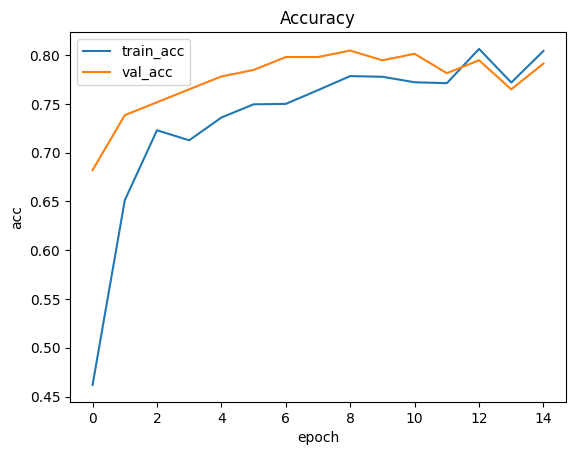

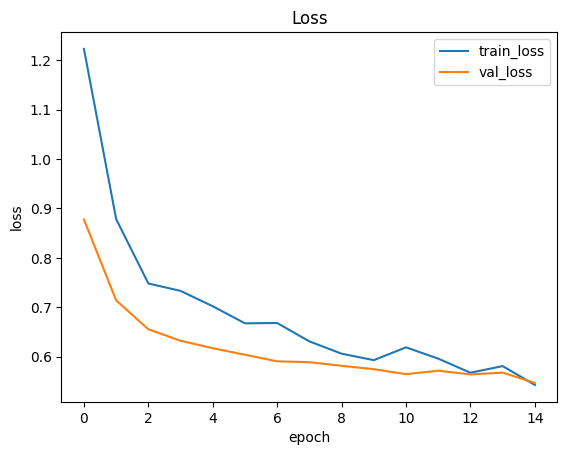

In [ ]:
ckpt_path = "waste_best.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy",
                                    save_best_only=True, mode="max", verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,
                                  restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2,
                                      patience=2, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

# Plot training curves (optional)
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.show()


In [ ]:
# Unfreeze top ~30% of EfficientNet layers
base.trainable = True
for layer in base.layers[: round(0.7 * len(base.layers))]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # lower LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
     37/Unknown 165s 4s/step - accuracy: 0.6871 - loss: 0.8160
Epoch 1: val_accuracy did not improve from 0.80464
37/37 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.6879 - loss: 0.8144 - val_accuracy: 0.7781 - val_loss: 0.5792 - learning_rate: 1.0000e-04
Epoch 2/10
38/37 ━━━━━━━━━━━━━━━━━━━━ -3s 4s/step - accuracy: 0.7400 - loss: 0.6588
Epoch 2: val_accuracy improved from 0.80464 to 0.81126, saving model to waste_best.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 175s 5s/step - accuracy: 0.7407 - loss: 0.6581 - val_accuracy: 0.8113 - val_loss: 0.5407 - learning_rate: 1.0000e-04
Epoch 3/10
35/37 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.8022 - loss: 0.5125 
Epoch 3: val_accuracy did not improve from 0.81126
37/37 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - accuracy: 0.8023 - loss: 0.5135 - val_accuracy: 0.8046 - val_loss: 0.5247 - learning_rate: 1.0000e-04
Epoch 4/10
36/37 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.8175 - loss: 0.5156
Epoch 4: val_accuracy did not improve from 0.81126
3

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8909 - loss: 0.3863
Test Accuracy: 0.8523


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step
                precision    recall  f1-score   support

     Hazardous       0.89      0.95      0.92        44
Non-Recyclable       0.81      0.85      0.83        52
       Organic       0.89      0.83      0.86        48
    Recyclable       0.80      0.75      0.77        32

      accuracy                           0.85       176
     macro avg       0.85      0.85      0.85       176
  weighted avg       0.85      0.85      0.85       176



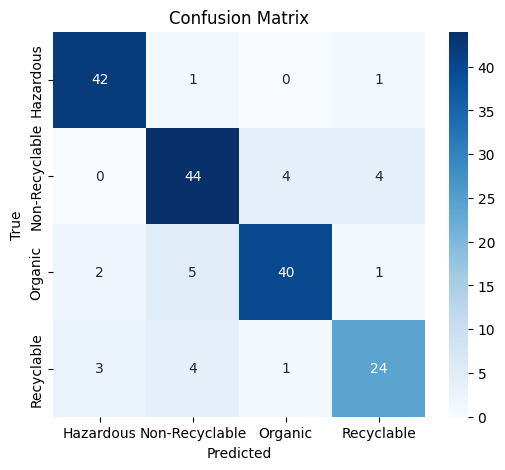

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("waste_classifier.h5")


In [ ]:
# Recommended (new format)
model.save("waste_classifier.keras")


In [ ]:
import pathlib

bad_files = []
for folder in ["train", "val", "test"]:
    path = pathlib.Path(DATA_DIR) / folder
    for f in path.rglob("*"):
        if f.is_file():
            if not f.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".gif"]:
                bad_files.append(str(f))

print("Found", len(bad_files), "non-image files")
for f in bad_files[:20]:
    print(f)


Found 0 non-image files


In [ ]:
for f in bad_files:
    os.remove(f)


In [ ]:
from PIL import Image

for folder in ["train", "val", "test"]:
    path = pathlib.Path(DATA_DIR) / folder
    for f in path.rglob("*.jpg"):
        try:
            img = Image.open(f)
            img.verify()
        except Exception as e:
            print("Corrupted:", f, e)


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
from PIL import Image
import pathlib, os

corrupted = []
for folder in ["train", "val", "test"]:
    path = pathlib.Path(DATA_DIR) / folder
    for f in path.rglob("*.*"):
        try:
            img = Image.open(f)
            img.verify()  # check if image is valid
        except Exception as e:
            print("Corrupted:", f, e)
            corrupted.append(f)

print("Total corrupted files:", len(corrupted))

# remove them if you want
for f in corrupted:
    os.remove(f)


Total corrupted files: 0


In [ ]:
import pathlib

tiffs = []
for folder in ["train", "val", "test"]:
    path = pathlib.Path(DATA_DIR) / folder
    for f in path.rglob("*.tif*"):  # catches .tif and .tiff
        tiffs.append(f)

print("Found", len(tiffs), "TIFF files")
for f in tiffs:
    print(f)


Found 0 TIFF files


In [ ]:
train_ds = train_ds.apply(tf.data.experimental.ignore_errors())
val_ds   = val_ds.apply(tf.data.experimental.ignore_errors())
test_ds  = test_ds.apply(tf.data.experimental.ignore_errors())


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [ ]:
train_ds = train_ds.ignore_errors()
val_ds   = val_ds.ignore_errors()
test_ds  = test_ds.ignore_errors()
